In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd "/content/drive/MyDrive/wildproj"

/content/drive/MyDrive/wildproj


In [ ]:
%pwd

'/content/drive/MyDrive/wildproj'

In [ ]:
base_path = "./iwildcam-2020-fgvc7"
base_path

'./iwildcam-2020-fgvc7'

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, auc, precision_recall_curve
import seaborn as sns
import cv2
from PIL import Image, ImageDraw

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.models import vit_b_16
import torch
import torch.optim as optim

In [ ]:
%matplotlib inline
np.random.seed(18)

In [ ]:
import glob
train_jpeg = glob.glob('./iwildcam-2020-fgvc7/train/*')
test_jpeg = glob.glob('./iwildcam-2020-fgvc7/test/*')

print("Number of Training data:", len(train_jpeg))
print("Number of Testing data:", len(test_jpeg))

Number of Training data: 10
Number of Testing data: 10


In [ ]:
import json
with open('./iwildcam-2020-fgvc7/iwildcam2020_train_annotations.json') as f:
    data = json.load(f)

data.keys()

dict_keys(['annotations', 'images', 'categories', 'info'])

In [ ]:
labels = pd.DataFrame(data['annotations'])
labels.head()

count                              image_id  \
0      1  96b00332-21bc-11ea-a13a-137349068a90   
1      1  879d74d8-21bc-11ea-a13a-137349068a90   
2      1  9017f7aa-21bc-11ea-a13a-137349068a90   
3      1  90d93c58-21bc-11ea-a13a-137349068a90   
4      1  887cd0ec-21bc-11ea-a13a-137349068a90   

                                     id  category_id  
0  a292dd3c-21bc-11ea-a13a-137349068a90           73  
1  a0afcfc0-21bc-11ea-a13a-137349068a90            4  
2  a306e9c0-21bc-11ea-a13a-137349068a90          227  
3  9eed94c4-21bc-11ea-a13a-137349068a90          250  
4  a2a4dd7a-21bc-11ea-a13a-137349068a90            2

In [ ]:
image_df = pd.DataFrame(data["images"])
image_df.head()

seq_num_frames  location                 datetime  \
0               1       267  2013-08-08 11:45:00.000   
1               1       264  2013-08-01 22:31:00.000   
2               1        45  2013-04-17 11:15:00.000   
3               1        45  2013-04-23 08:26:00.000   
4               1        45  2013-04-24 13:51:00.000   

                                     id  frame_num  \
0  96b00332-21bc-11ea-a13a-137349068a90          1   
1  879d74d8-21bc-11ea-a13a-137349068a90          1   
2  9017f7aa-21bc-11ea-a13a-137349068a90          1   
3  90d93c58-21bc-11ea-a13a-137349068a90          1   
4  887cd0ec-21bc-11ea-a13a-137349068a90          1   

                                 seq_id  width  height  \
0  96b004ea-21bc-11ea-a13a-137349068a90   1795    1222   
1  879d7654-21bc-11ea-a13a-137349068a90   2739    1772   
2  9017f8cc-21bc-11ea-a13a-137349068a90   1891    1222   
3  90d93e38-21bc-11ea-a13a-137349068a90   1795    1222   
4  887cd29a-21bc-11ea-a13a-137349068a90   1812    1196   

                                  file_name  
0  96b00332-21bc-11ea-a13a-137349068a90.jpg  
1  879d74d8-21bc-11ea-a13a-137349068a90.jpg  
2  9017f7aa-21bc-11ea-a13a-137349068a90.jpg  
3  90d93c58-21bc-11ea-a13a-137349068a90.jpg  
4  887cd0ec-21bc-11ea-a13a-137349068a90.jpg

In [ ]:
df_categories = pd.DataFrame(data['categories'])
df_categories.T

0               1                    2               3    \
count  78981            6355                 5833             619   
id         0               2                    3               4   
name   empty  tayassu pecari  dasyprocta punctata  cuniculus paca   

                 4                   5              6                 7    \
count           4453                 129           1181               330   
id                 6                   7              8                 9   
name   puma concolor  tapirus terrestris  pecari tajacu  mazama americana   

                      8                  9    ...            257  \
count                5824                480  ...              2   
id                     10                 12  ...            666   
name   leopardus pardalis  geotrygon montana  ...  pipile pipile   

                           258                   259                260  \
count                        2                    57                  0   
id                         667                   668                669   
name   metachirus nudicaudatus  funisciurus pyrropus  alethe poliophrys   

                           261                      262              263  \
count                        0                        6                3   
id                         670                      671              672   
name   ruwenzorornis johnstoni  thryonomys swinderianus  ploceus alienus   

                      264                    265                   266  
count                   3                      2                     6  
id                    673                    674                   675  
name   ploceus baglafecht  poecilogale albinucha  anomalurus derbianus  

[3 rows x 267 columns]

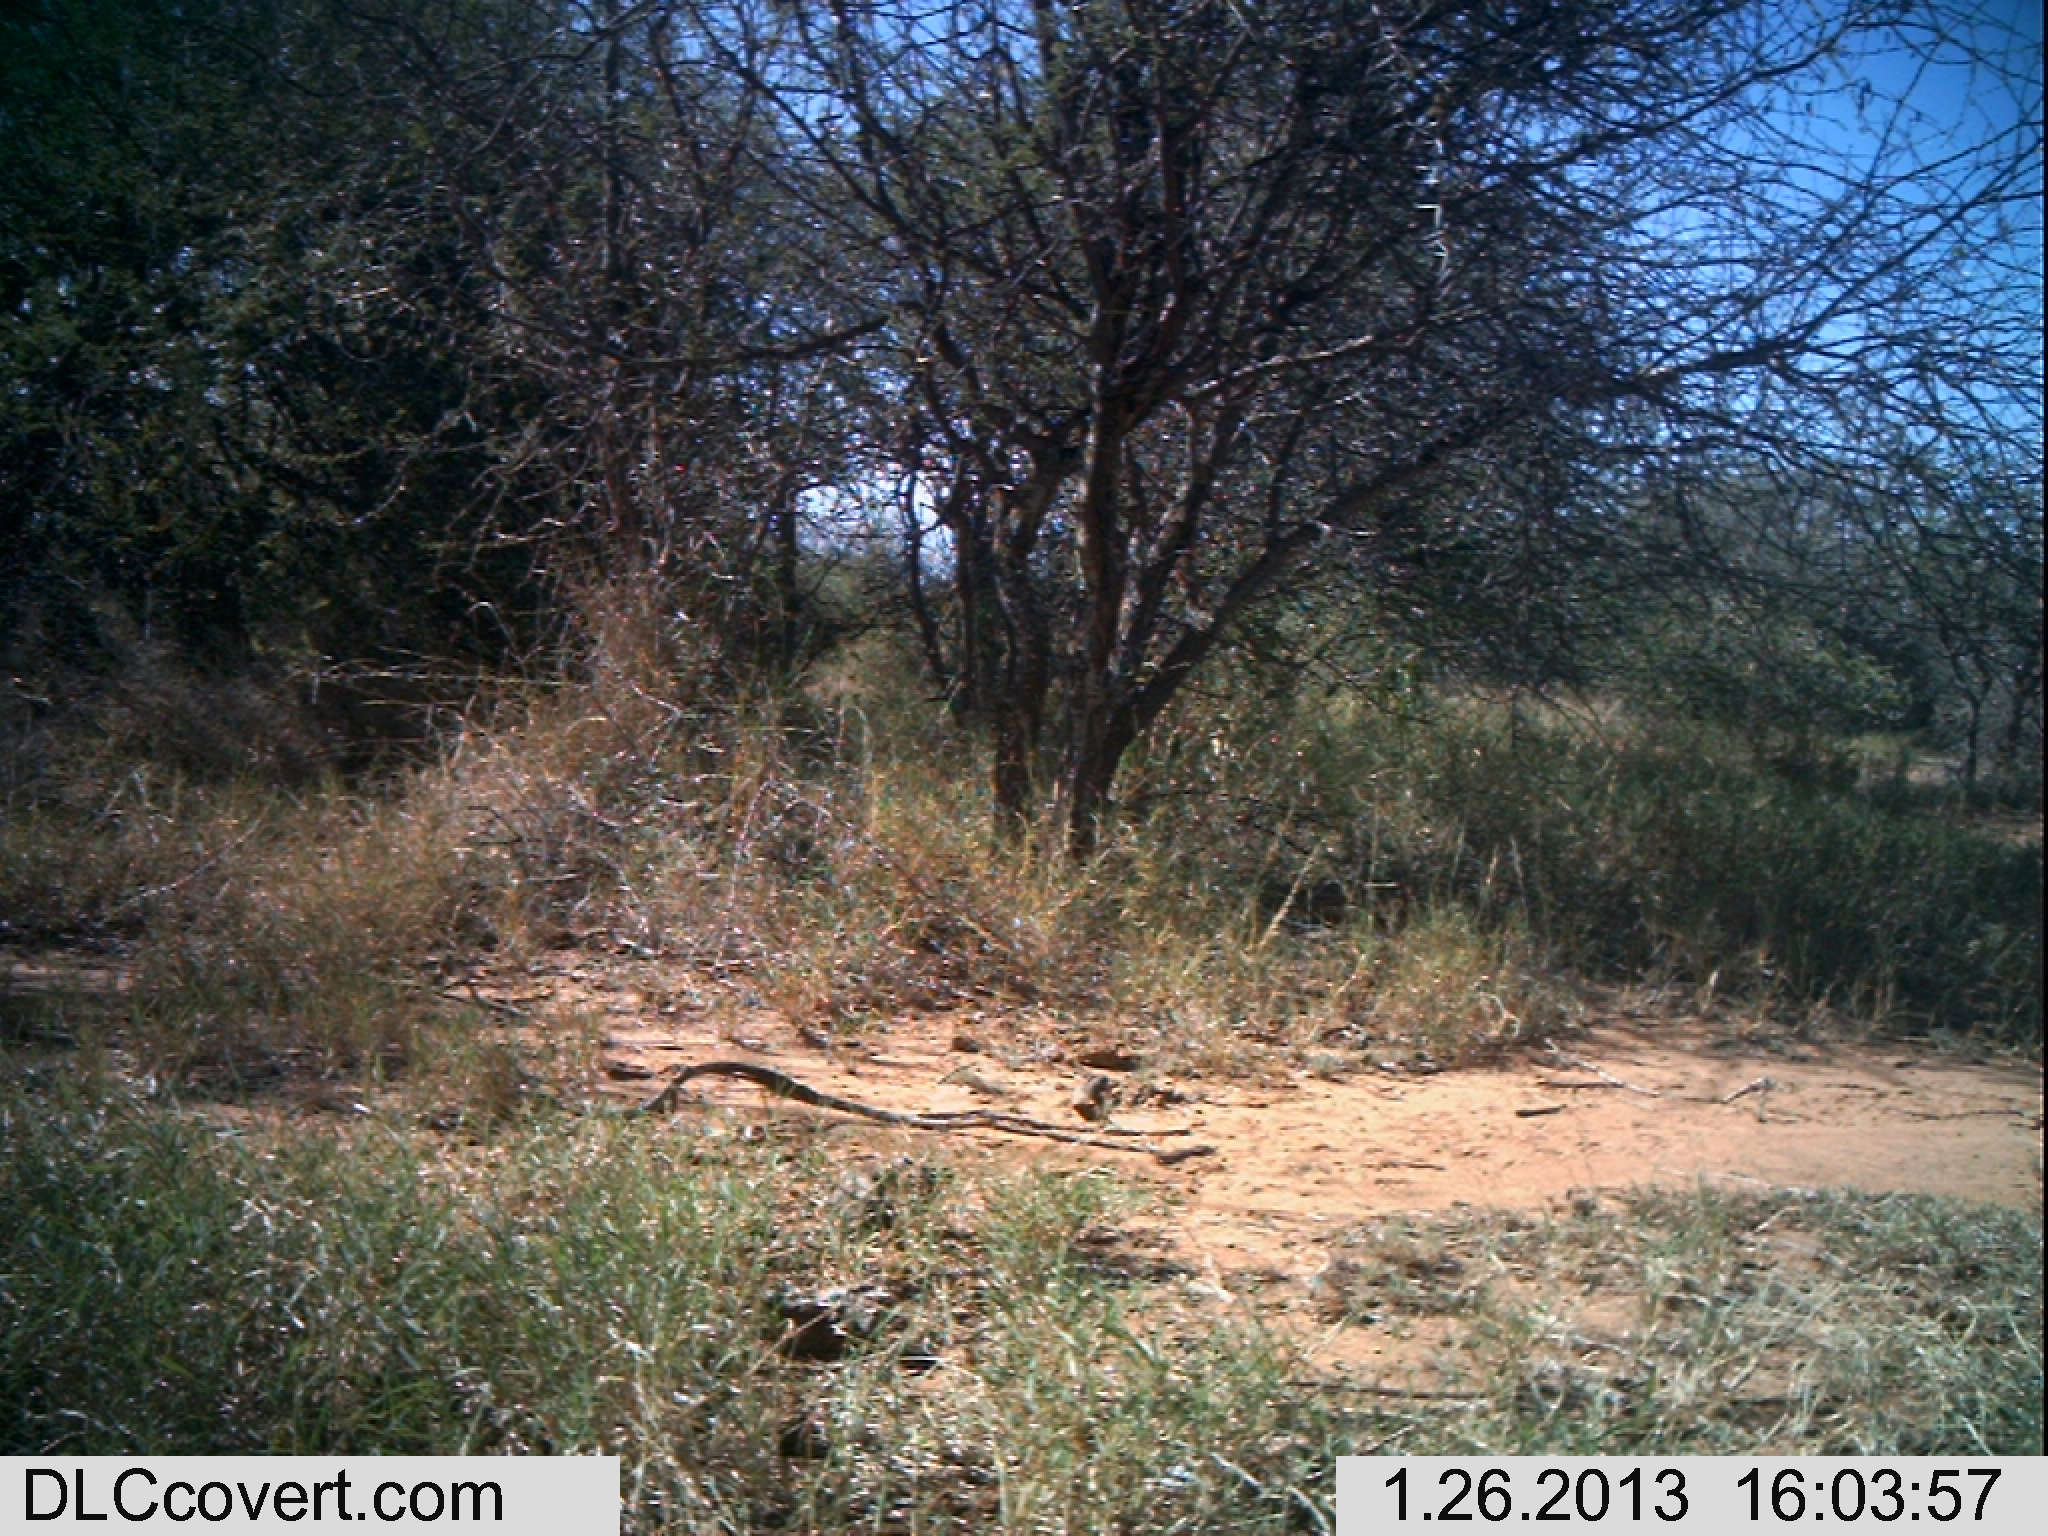

In [ ]:
from IPython.display import Image
Image(filename="./iwildcam-2020-fgvc7/train/8a00a970-21bc-11ea-a13a-137349068a90.jpg")

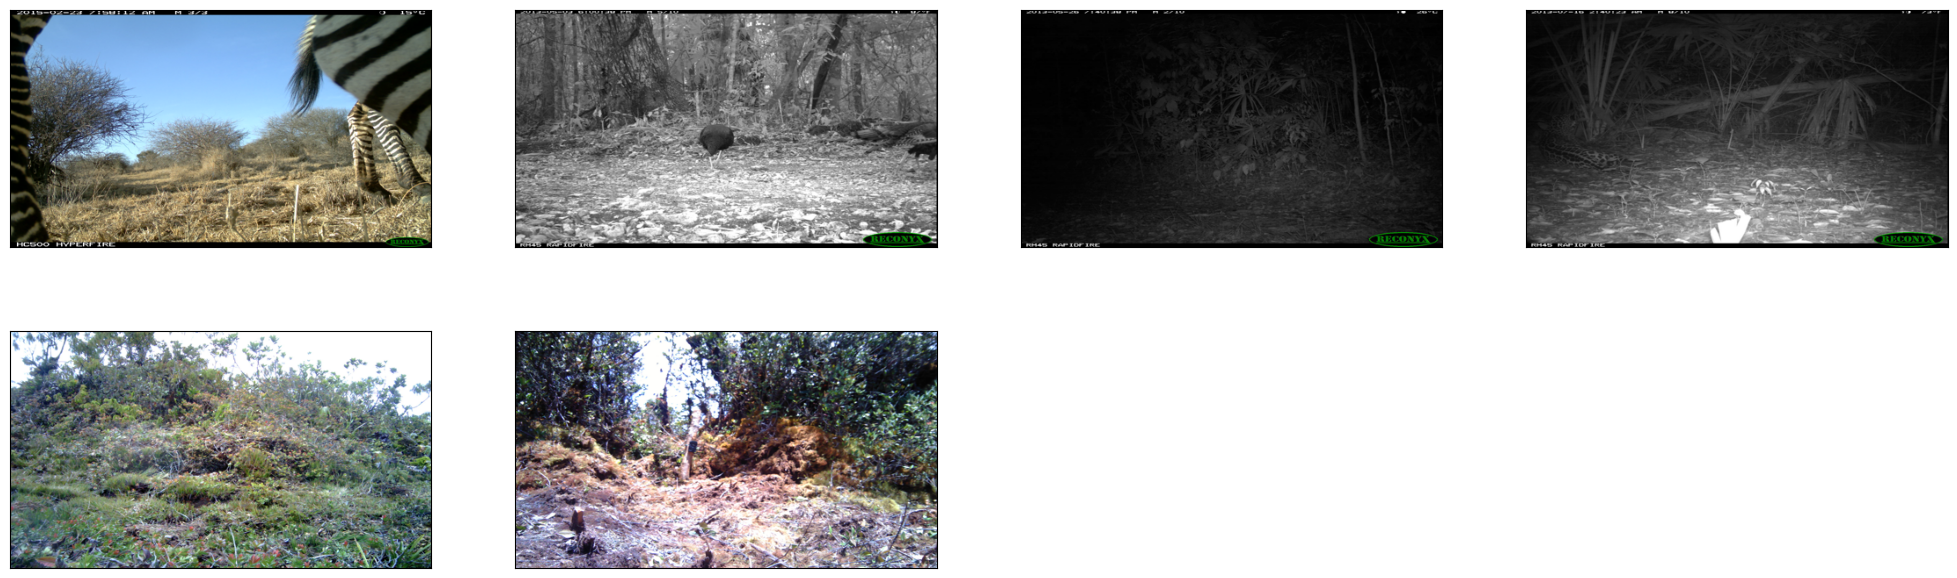

In [ ]:
from PIL import Image

fig = plt.figure(figsize=(25, 16))
for i,im_path in enumerate(train_jpeg[:6]):
    ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    im = Image.open(im_path)
    im = im.resize((480,270))
    plt.imshow(im)

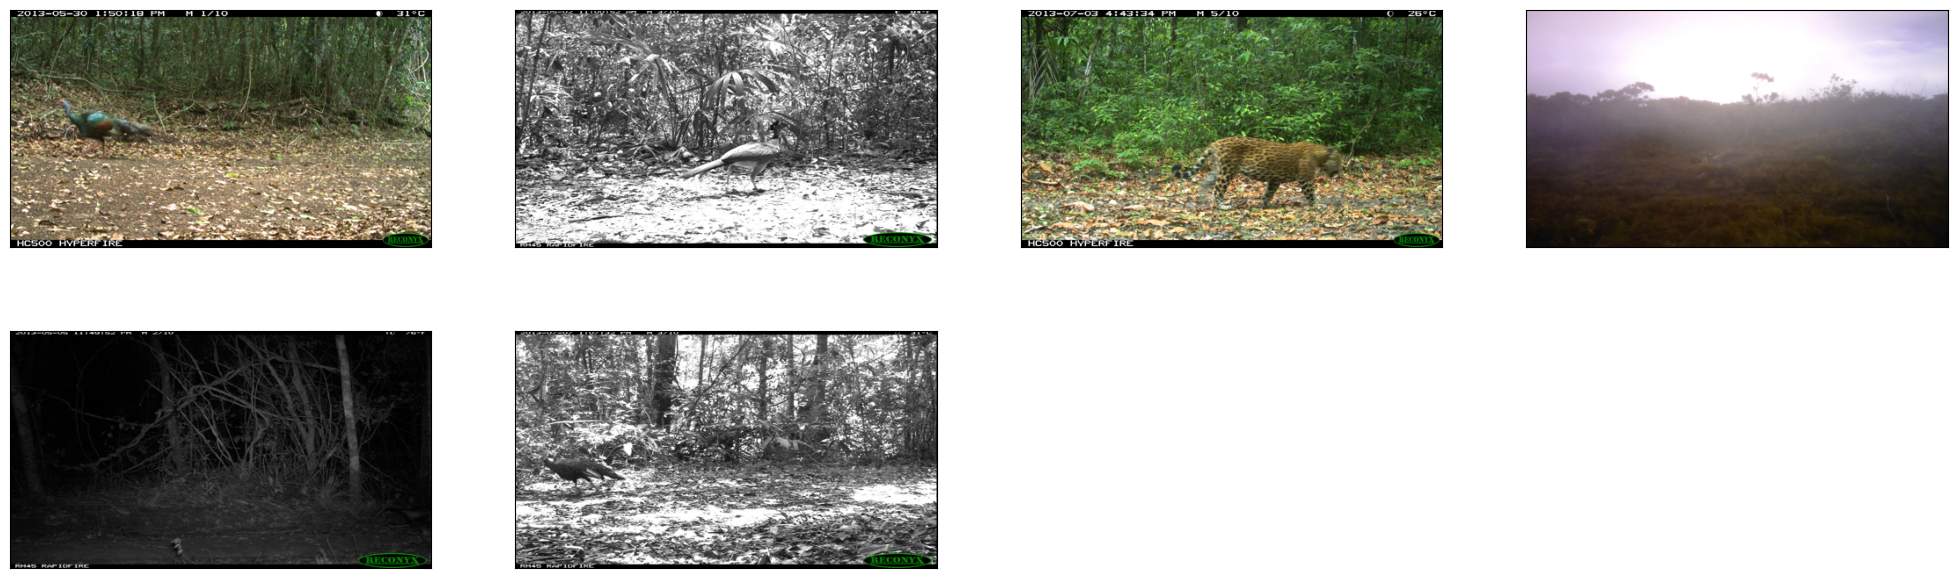

In [ ]:
fig = plt.figure(figsize=(25, 16))
for i,im_path in enumerate(test_jpeg[:6]):
    ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    im = Image.open(im_path)
    im = im.resize((480,270))
    plt.imshow(im)

In [ ]:
%pwd

'/content/drive/MyDrive/wildproj'

In [ ]:
batch_size = 32
IMG_SIZE = 224
N_EPOCHS = 10
ID_COLNAME = 'file_name'
ANSWER_COLNAME = 'category_id'
TRAIN_IMGS_DIR = './iwildcam-2020-fgvc7/train'
TEST_IMGS_DIR = './iwildcam-2020-fgvc7/train'

In [ ]:
train_df_all = pd.read_csv('./wildcamtrain/train.csv')
train_df_all.head()

category_id        date_captured                                 file_name  \
0           19  2011-05-13 23:43:18  5998cfa4-23d2-11e8-a6a3-ec086b02610b.jpg   
1           19  2012-03-17 03:48:44  588a679f-23d2-11e8-a6a3-ec086b02610b.jpg   
2            0  2014-05-11 11:56:46  59279ce3-23d2-11e8-a6a3-ec086b02610b.jpg   
3            0  2013-10-06 02:00:00  5a2af4ab-23d2-11e8-a6a3-ec086b02610b.jpg   
4            0  2011-07-12 13:11:16  599fbd89-23d2-11e8-a6a3-ec086b02610b.jpg   

   frame_num                                    id  location  rights_holder  \
0          1  5998cfa4-23d2-11e8-a6a3-ec086b02610b        33   Justin Brown   
1          2  588a679f-23d2-11e8-a6a3-ec086b02610b       115   Justin Brown   
2          1  59279ce3-23d2-11e8-a6a3-ec086b02610b        96  Erin Boydston   
3          1  5a2af4ab-23d2-11e8-a6a3-ec086b02610b        57  Erin Boydston   
4          3  599fbd89-23d2-11e8-a6a3-ec086b02610b        46   Justin Brown   

                                 seq_id  seq_num_frames  width  height  
0  6f084ccc-5567-11e8-bc84-dca9047ef277               3   1024     747  
1  6f12067d-5567-11e8-b3c0-dca9047ef277               3   1024     747  
2  6faa92d1-5567-11e8-b1ae-dca9047ef277               1   1024     747  
3  6f7d4702-5567-11e8-9e03-dca9047ef277               1   1024     747  
4  6f1728a1-5567-11e8-9be7-dca9047ef277               3   1024     747

In [ ]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(train_df_all[[ID_COLNAME, ANSWER_COLNAME]],
                                     test_size = 0.15,
                                     shuffle = True
                                    )

In [ ]:
NUM_CLASSES = 14
CLASSES_TO_USE = train_df_all['category_id'].unique()

In [ ]:
CLASSMAP = dict(
    [(i, j) for i, j
     in zip(CLASSES_TO_USE, range(NUM_CLASSES))
    ]
)
CLASSMAP

{19: 0,
 0: 1,
 3: 2,
 8: 3,
 4: 4,
 13: 5,
 1: 6,
 11: 7,
 16: 8,
 17: 9,
 14: 10,
 18: 11,
 10: 12,
 22: 13}

In [ ]:
import os
import cv2
from PIL import Image
import torch
from torch.utils.data import Dataset

class IMetDataset(Dataset):
    def __init__(self, df, images_dir, n_classes=14, id_colname='ID', answer_colname='ANSWER', label_dict=None, transforms=None):
        self.df = df
        self.images_dir = images_dir
        self.n_classes = n_classes
        self.id_colname = id_colname
        self.answer_colname = answer_colname
        self.label_dict = label_dict
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        cur_idx_row = self.df.iloc[idx]
        img_id = cur_idx_row[self.id_colname]
        img_name = img_id  # Ensure img_name has the proper file extension if needed
        img_path = os.path.join(self.images_dir, img_name)

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = Image.fromarray(img)

        if self.transforms:
            img = self.transforms(img)

        if self.answer_colname is not None:
            label = torch.zeros((self.n_classes,), dtype=torch.float32)
            label[self.label_dict[cur_idx_row[self.answer_colname]]] = 1.0
            return img, label
        else:
            return img, img_id


In [ ]:
# %pip install torchinfo

In [ ]:
import os
import json
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch
import torch.optim as optim
from torchvision.models import vit_b_16
from torchinfo import summary

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to fit the ViT input size
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize images
])

# Load dataset
train_dataset = IMetDataset(train_df, TRAIN_IMGS_DIR, transforms = transform)
dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)  # Assume img_size is size of images, adjust as necessary

# Load a pre-trained ViT model
model = vit_b_16(pretrained=True)

# Adapt the classifier to the number of classes in iWildCam-2020
model.heads[0] = torch.nn.Linear(model.heads[0].in_features, 267)

# Loss function
criterion = torch.nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Optionally, add a scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Assuming summary is a function from the torchsummary package
summary(model, input_size=(32, 3, 224, 224))


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer (type:depth-idx)                        Output Shape              Param #
VisionTransformer                             [32, 267]                 768
├─Conv2d: 1-1                                 [32, 768, 14, 14]         590,592
├─Encoder: 1-2                                [32, 197, 768]            151,296
│    └─Dropout: 2-1                           [32, 197, 768]            --
│    └─Sequential: 2-2                        [32, 197, 768]            --
│    │    └─EncoderBlock: 3-1                 [32, 197, 768]            7,087,872
│    │    └─EncoderBlock: 3-2                 [32, 197, 768]            7,087,872
│    │    └─EncoderBlock: 3-3                 [32, 197, 768]            7,087,872
│    │    └─EncoderBlock: 3-4                 [32, 197, 768]            7,087,872
│    │    └─EncoderBlock: 3-5                 [32, 197, 768]            7,087,872
│    │    └─EncoderBlock: 3-6                 [32, 197, 768]            7,087,872
│    │    └─EncoderBlock: 3-7             

In [ ]:
train_anns_df = labels[['image_id','category_id']]
train_img_df = image_df[['id', 'file_name']].rename(columns={'id':'image_id'})
df_train_file_cat = pd.merge(train_img_df, train_anns_df, on='image_id')
df_train_file_cat['category_id']=df_train_file_cat['category_id'].astype(str)
df_train_file_cat.head()

image_id  \
0  96b00332-21bc-11ea-a13a-137349068a90   
1  879d74d8-21bc-11ea-a13a-137349068a90   
2  9017f7aa-21bc-11ea-a13a-137349068a90   
3  90d93c58-21bc-11ea-a13a-137349068a90   
4  887cd0ec-21bc-11ea-a13a-137349068a90   

                                  file_name category_id  
0  96b00332-21bc-11ea-a13a-137349068a90.jpg          73  
1  879d74d8-21bc-11ea-a13a-137349068a90.jpg           4  
2  9017f7aa-21bc-11ea-a13a-137349068a90.jpg         227  
3  90d93c58-21bc-11ea-a13a-137349068a90.jpg         250  
4  887cd0ec-21bc-11ea-a13a-137349068a90.jpg           2

In [ ]:
with open('./iwildcam-2020-fgvc7/iwildcam2020_megadetector_results.json', encoding='utf-8') as json_file:
    megadetector_results =json.load(json_file)

megadetector_results.keys()

dict_keys(['info', 'images', 'detection_categories'])

In [ ]:
megadetector_results_df = pd.DataFrame(megadetector_results["images"])
megadetector_results_df.head()

detections  \
0  [{'category': '1', 'bbox': [0.6529, 0.5425, 0....   
1  [{'category': '1', 'bbox': [0.0147, 0.0, 0.985...   
2                                                 []   
3  [{'category': '1', 'bbox': [0.0, 0.4669, 0.185...   
4  [{'category': '1', 'bbox': [0.0, 0.0494, 0.528...   

                                     id  max_detection_conf  
0  905a3c8c-21bc-11ea-a13a-137349068a90               0.999  
1  905a3fc0-21bc-11ea-a13a-137349068a90               0.696  
2  905a420e-21bc-11ea-a13a-137349068a90               0.000  
3  905a4416-21bc-11ea-a13a-137349068a90               1.000  
4  905a579e-21bc-11ea-a13a-137349068a90               0.999

In [ ]:
def draw_bboxs(detections_list, im):

    for detection in detections_list:
        x1, y1,w_box, h_box = detection["bbox"]
        ymin,xmin,ymax, xmax=y1, x1, y1 + h_box, x1 + w_box
        draw = ImageDraw.Draw(im)

        imageWidth=im.size[0]
        imageHeight= im.size[1]
        (left, right, top, bottom) = (xmin * imageWidth, xmax * imageWidth,
                                      ymin * imageHeight, ymax * imageHeight)

        draw.line([(left, top), (left, bottom), (right, bottom),
               (right, top), (left, top)], width=4, fill='Red')

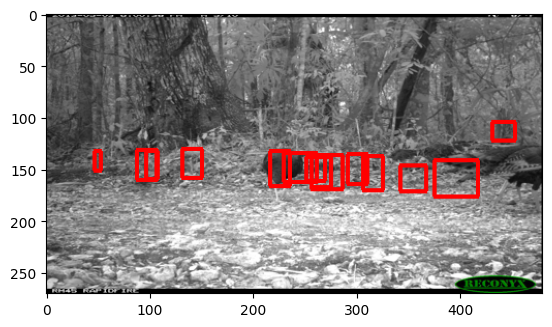

In [ ]:
data_num = 5678

# im = Image.open("./iwildcam-2020-fgvc7/train/" + megadetector_results_df.loc[data_num]['id'] + ".jpg")
im = Image.open("/content/drive/MyDrive/wildproj/iwildcam-2020-fgvc7/train/8a00b3f2-21bc-11ea-a13a-137349068a90.jpg")
im = im.resize((480,270))
draw_bboxs(megadetector_results_df.loc[data_num]['detections'], im)

plt.imshow(im);

In [ ]:
# fig = plt.figure(figsize=(25, 16))

# for i in range(16):
#     ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
#     im = Image.open("../input/iwildcam-2020-fgvc7/train/" + megadetector_results_df.loc[i]['id'] + ".jpg")
#     draw_bboxs(megadetector_results_df.loc[i]['detections'], im)
#     im = im.resize((480,270))
#     plt.imshow(im)

In [ ]:
print(megadetector_results_df.columns)


Index(['detections', 'id', 'max_detection_conf'], dtype='object')


In [ ]:
# megadetector_results_df = megadetector_results_df[megadetector_results_df['detected_num'] < 2]
# megadetector_results_df = megadetector_results_df.rename(columns={'id': 'image_id'})
# megadetector_results_df.head()

KeyError: 'detected_num'

In [ ]:
def get_data(x):
    if x == []:
        return 0
    return len(x)

megadetector_results_df["detected_num"] = megadetector_results_df.loc[:, "detections"].map(get_data)

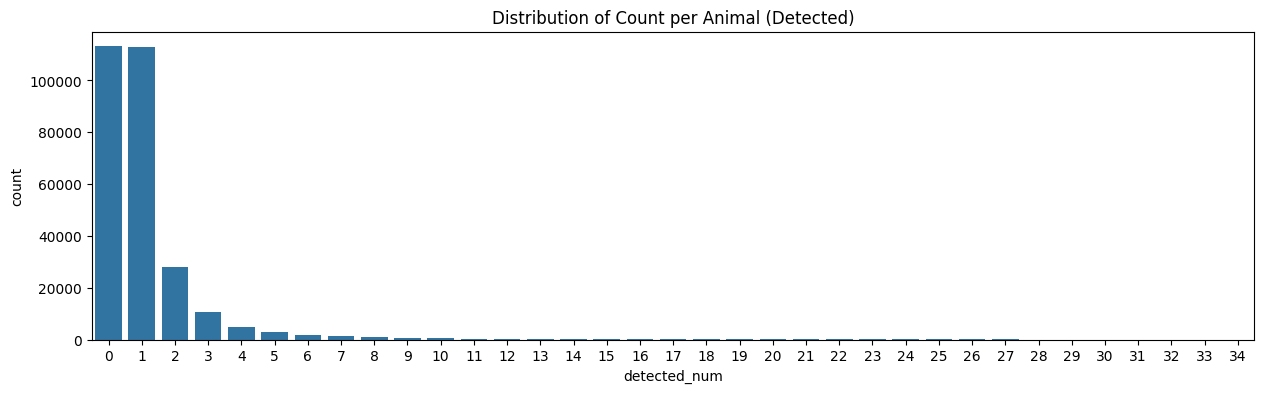

In [ ]:
fig = plt.figure(figsize=(15, 4))
ax = sns.countplot(x="detected_num", data=megadetector_results_df)
ax.set(ylabel='count')
plt.title('Distribution of Count per Animal (Detected)');

In [ ]:
batch_size = 256
img_size = 96
lr = 0.001
nb_classes = 267
nb_epochs = 10

In [ ]:
# %%time

# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# train_datagen=ImageDataGenerator(rescale=1./255,
#     validation_split=0.25,
#     horizontal_flip = True,
#     zoom_range = 0.3,
#     width_shift_range = 0.3,
#     height_shift_range=0.3
#     )

# train_generator=train_datagen.flow_from_dataframe(
#     dataframe=df_train_file_cat[:50000],
#     directory="../input/iwildcam-2020-fgvc7/train",
#     x_col="file_name",
#     y_col="category_id",
#     batch_size=batch_size,
#     shuffle=True,
#     classes = [ str(i) for i in range(nb_classes)],
#     class_mode="categorical",
#     target_size=(img_size,img_size))

# test_datagen = ImageDataGenerator(rescale=1./255)

# valid_generator=test_datagen.flow_from_dataframe(
#     dataframe=df_train_file_cat[50000:],
#     directory="../input/iwildcam-2020-fgvc7/train",
#     x_col="file_name",
#     y_col="category_id",
#     batch_size=batch_size,
#     shuffle=True,
#     classes = [ str(i) for i in range(nb_classes)],
#     class_mode="categorical",
#     target_size=(img_size,img_size))

In [ ]:
print(dataloader.dataset.df.columns)

Index(['file_name', 'category_id'], dtype='object')


In [ ]:
%pwd

'/content/drive/MyDrive/wildproj'

In [ ]:
%%time

import time

for epoch in range(5):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    start_time = time.time()  # Start time of the epoch
    total_batches = 0  # Track number of successful batches

    for i, data in enumerate(dataloader):
        try:
            images, labels = data
            images, labels = images.to(device), labels.to(device)  # Move data to the appropriate device

            optimizer.zero_grad()  # Zero the gradients to prepare for a new gradient computation

            outputs = model(images)  # Forward pass: compute the output of the model
            loss = criterion(outputs, labels)  # Calculate the loss

            loss.backward()  # Backward pass: compute the gradient of the loss w.r.t the model's weights
            optimizer.step()  # Perform a single optimization step

            running_loss += loss.item()  # Accumulate the loss
            total_batches += 1  # Increment successful batch count

            if (i + 1) % 100 == 0:  # Print the average loss every 100 batches
                print(f'Epoch {epoch+1}, Batch {i+1}, Current Loss: {loss.item()}')

        except Exception as e:
            print(f"Skipping batch {i+1} due to an error: {e}")

    if total_batches > 0:
        epoch_duration = time.time() - start_time  # Calculate the duration of the epoch
        average_loss = running_loss / total_batches  # Calculate the average loss for the epoch
        print(f'Epoch {epoch+1} completed in {epoch_duration:.2f} seconds, Loss: {average_loss}')
    else:
        print(f'Epoch {epoch+1}: No successful batches were processed.')

    scheduler.step()  # Step the learning rate scheduler

torch.save(model.state_dict(), 'iwildcam_vit_model.pth')  # Save the model weights


KeyError: 'ID'

In [ ]:
sam_sub_df = pd.read_csv('./iwildcam-2020-fgvc7/sample_submission.csv')
sam_sub_df["file_name"] = sam_sub_df["Id"].map(lambda str : str + ".jpg")
sam_sub_df.head()

In [ ]:
%%time

test_generator = test_datagen.flow_from_dataframe(

        dataframe=sam_sub_df,

        directory = "../input/iwildcam-2020-fgvc7/test",
        x_col="file_name",
        target_size = (img_size,img_size),
        batch_size = 1,
        classes = [ str(i) for i in range(nb_classes)],
        shuffle = False,
        class_mode = None
        )

In [ ]:
%%time

test_generator.reset()
predict=model.predict_generator(test_generator,
                                steps = len(test_generator.filenames))

predicted_class_indices = np.argmax(predict, axis=1)

sam_sub_df["Category"] = predicted_class_indices
sam_sub_df = sam_sub_df.loc[:,["Id", "Category"]]
sam_sub_df.to_csv("submission.csv", index=False)